# Requirements

In [3]:
import zipfile
import pandas as pd
import os
import glob
from tqdm.auto import tqdm
from IPython.display import display

# Unzipping the dataset

In [4]:
with zipfile.ZipFile("Datasets/archive.zip", 'r') as zip_ref:
    zip_ref.extractall("Datasets")

# Reading the csv

In [5]:
tqdm.pandas()
path = os.getcwd() + "/Datasets"
csv_files = glob.glob(os.path.join(path, "*.csv"))
csv_dfs = {}
for f in csv_files:
    file_name = f.split("\\")[-1]
    
    # remove the .csv extension
    file_name = file_name[:-4]
    
    if file_name == "Amazon-Products":
        continue
    
    # read the csv file 
    df = pd.read_csv(f)
    csv_dfs[file_name] = df

## Usage

In [6]:
display(csv_dfs["Amazon Fashion"])

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,Aqualogica Glow+ Dewy Sunscreen SPF 50 PA+++ F...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/51TSC6Uogx...,https://www.amazon.in/Aqualogica-Sunscreen-Pro...,4.2,"3,628",₹351,₹399
1,MARVIK Soft Silicone Adjustable Band Strap Com...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/51vYDop04S...,https://www.amazon.in/MARVIK-Silicone-Adjustab...,3.9,291,₹249,₹999
2,108 Panchatantra Stories for Children (Illustr...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/81VJ+MAc7Y...,https://www.amazon.in/108-Panchatantra-Stories...,4.4,"2,950",₹125,₹160
3,Black and White and Blue: Adult Cinema From th...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/51RIhaW3t1...,https://www.amazon.in/Black-White-Blue-Cinema-...,4.2,8,NaN,₹584.16
4,SAFARI 15 Ltrs Sea Blue Casual/School/College ...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/61kmCas5OC...,https://www.amazon.in/SAFARI-Ltrs-Casual-Backp...,4.0,"17,985",₹299,₹799
...,...,...,...,...,...,...,...,...,...
2347,"Lakme Lip Love Gelato Lip Balm - Pink, Bubbleg...",stores,Amazon Fashion,https://m.media-amazon.com/images/I/61lc+uAfF0...,https://www.amazon.in/LAKM%C3%89-Love-Gelato-C...,4.1,515,₹148,₹199
2348,SATTVA Classy.Elegant.Stylish Classic XXXL Bea...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/71zaq78pO8...,https://www.amazon.in/Sattva-Classic-Filled-Be...,4.2,10,"₹2,170","₹4,299"
2349,Fastrack Glitch Analog Rose Gold Dial Women's ...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/61B+fqeyzj...,https://www.amazon.in/Fastrack-Glitch-Analog-W...,3.5,16,NaN,"₹5,595"
2350,NAINVISH Women/Girl's Pure Cotton Paisley Prin...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/81qATlsYzk...,https://www.amazon.in/NAINVISH-Cotton-Paisley-...,3.4,318,₹499,"₹2,599"


---
# Preprocessing

### Amazon Fashion

In [7]:
amazon_fashion_df = csv_dfs["Amazon Fashion"]
# drop rows with missing values  # TODO: can discount be Nan?
amazon_fashion_df = amazon_fashion_df.dropna()
# drop duplicates
amazon_fashion_df = amazon_fashion_df.drop_duplicates()
# drop rows with links that are not amazon links  # TODO: check if this is necessary
amazon_fashion_df = amazon_fashion_df[amazon_fashion_df["link"].str.contains("amazon.com")]
# drop rows with links that don't work  # FIXME: how?
amazon_fashion_df = amazon_fashion_df[amazon_fashion_df["link"].str.contains("404")]
# drop columns that are not needed
amazon_fashion_df = amazon_fashion_df.drop(columns=["main_category"])
# normalize the ratings column
amazon_fashion_df["rating"] = amazon_fashion_df["rating"] / 5.0

KeyError: 'rating'

---
# Visualizing the data





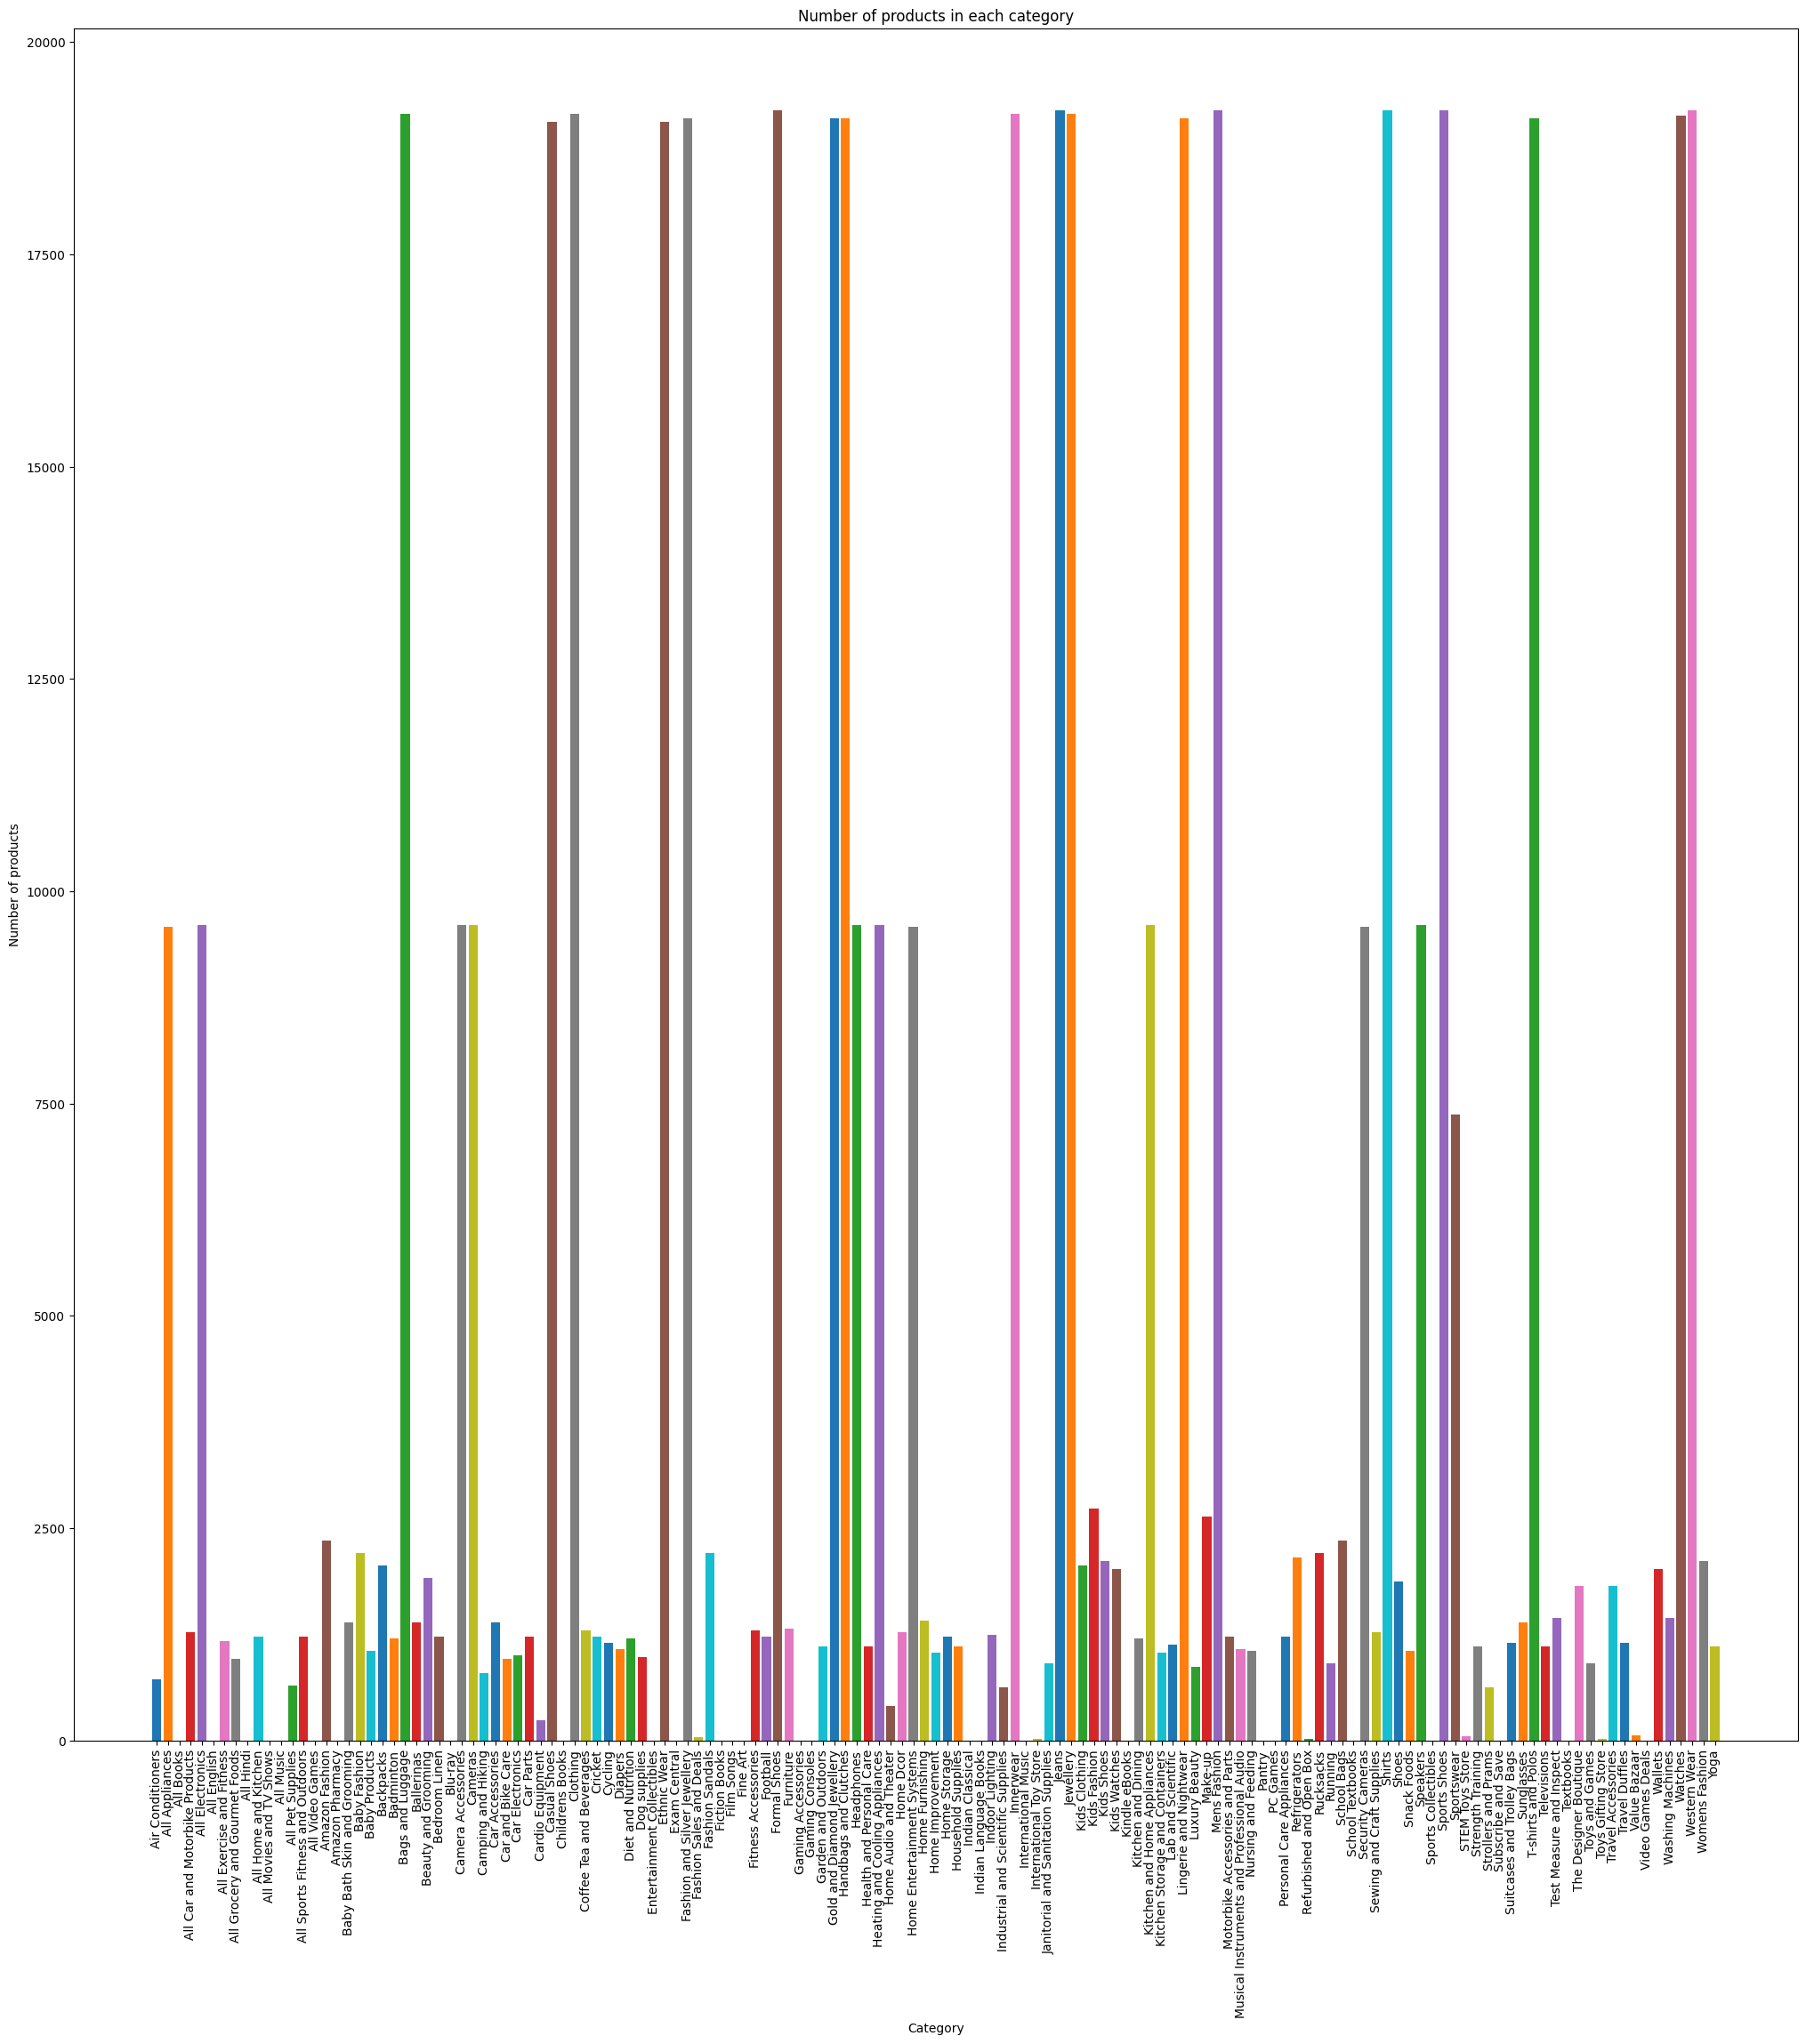

In [28]:
import matplotlib.pyplot as plt

plot = plt.figure()
plot.set_figwidth(25)
plot.set_figheight(25)
plt.xticks(rotation=90)

for key in csv_dfs:
    number_of_products = len(csv_dfs[key])
    plt.bar(key, number_of_products, label=key)
plt.xlabel('Category')
plt.ylabel('Number of products')
plt.title('Number of products in each category')

plt.show()



## Reality Check

## Exploration